In [ ]:
import random
import numpy as np
from pymoo.algorithms.base.genetic import GeneticAlgorithm
from pymoo.core.population import Population
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.binx import mut_binomial
from pymoo.operators.mutation.pm import PM
from pymoo.util.dominator import Dominator


class RLMODE(GeneticAlgorithm):

    def __init__(self,
                 pop_size=100,
                 n_offsprings=None,
                 sampling=FloatRandomSampling(),
                 crossover=mut_binomial(prob=0.9, eta=15),
                 mutation=PM(eta=20),
                 eliminate_duplicates=True,
                 **kwargs):
        
        super().__init__(
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            eliminate_duplicates=eliminate_duplicates,
            n_offsprings=n_offsprings,
            **kwargs
        )
        self.pop_size = pop_size
        
        # Initialize Q-table
        self.q_table = np.zeros((3, 3))  # 3 states, 3 actions
        
        # Initialize control parameters
        self.F = np.random.uniform(0, 1, pop_size)
        self.CR = np.random.uniform(0, 1, pop_size)
        
        # Initialize X state
        self.current_state = np.random.randint(3, size=pop_size)

    def _infill(self):
        # Create offsprings
        offsprings = []
        for i in range(self.pop_size):
            # DE mutation
            a, b, c = np.random.choice(self.pop_size, 3, replace=False)
            mutant = self.pop[a].X + self.F[i] * (self.pop[b].X - self.pop[c].X)
            
            # DE crossover
            mask = np.random.random(self.problem.n_var) < self.CR[i]
            offspring = np.where(mask, mutant, self.pop[i].X)
            
            offsprings.append(offspring)
        
        return Population.new(X=np.array(offsprings))
    
    def _initialize_advance(self):
        pass

    def _advance(self, infills=None, **kwargs):
        # Evaluate offspring
        self.evaluator.eval(self.problem, infills)

        # Combine parent and offspring populations
        pop = Population.merge(self.pop, infills)

        # Non-dominated sorting
        fronts = self.survival.do(self.problem, pop, self.pop_size, algorithm=self)

        # Update population
        self.pop = fronts[0][:self.pop_size]
        
        # RL updates
        for i in range(self.pop_size):
            parent = self.pop[i]
            offspring = infills[i]
            
            # Determine domination
            domination = Dominator.get_relation(parent.F, offspring.F)
            
            # Set state and reward
            if domination == 1:  # offspring dominates
                next_state = 0
                reward = 1
            elif domination == -1:  # parent dominates
                next_state = 1
                reward = -1
            else:  # non-dominated
                next_state = 2
                reward = 0
            
            # Select action and update control parameters
            action = np.argmax(self.q_table[self.current_state[i]])
            self.update_control_parameters(i, action)
            
            # Update Q-table
            self.update_q_table(self.current_state[i], action, reward, next_state)
            self.current_state[i] = next_state

    def update_control_parameters(self, index, action):
        if action == 0:
            self.F[index] -= 0.1
            self.CR[index] += 0.1
        elif action == 1:
            self.F[index] += 0.1
            self.CR[index] += 0.1
        # action == 2: do nothing
        
        # Ensure F and CR are within [0, 1]
        if self.F[index] > 1 or self.F[index] < 0:
            self.F[index] = random.uniform(0, 1)
        if self.CR[index] > 1 or self.CR[index] < 0:
            self.CR[index] = random.uniform(0, 1)

    def update_q_table(self, state, action, reward, next_state):
        learning_rate = 0.1
        discount_factor = 0.9
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
        self.q_table[state, action] = new_value

# Example usage
if __name__ == "__main__":
    from pymoo.problems import get_problem
    from pymoo.optimize import minimize
    from pymoo.visualization.scatter import Scatter

    problem = get_problem("zdt1")

    algorithm = RLMODE(
        pop_size=100,
        eliminate_duplicates=True
    )

    res = minimize(problem,
                   algorithm,
                   ('n_gen', 200),
                   seed=1,
                   verbose=True)

    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()

[2.4707060817789444, 2.4707060817789444, 2.4707060817789444, 2.2557634367096386, 2.2557634367096386, 1.1255034530526409, 1.1255034530526409, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.6791595442013798, 0.4831470737094672, 0.37452475262521345, 0.37452475262521345, 0.37452475262521345, 0.37452475262521345, 0.37452475262521345, 0.37452475262521345, 0.37452475262521345, 0.2790525397077972, 0.2790525397077972, 0.18202945558151395, 0.18202945558151395, 0.18202945558151395, 0.0891434823495108, 0.0891434823495108, 0.08599345545858053, 0.08599345545858053, 0.07985448243513972, 0.07985448243513972, 0.07985448243513972, 0.05396226480106499, 0.05396226480106499, 0.05396226480106499, 0.03968396220810658, 0.03968396220810658, 0.027677428040069414, 0.027677428040069414, 0.027677428040069414, 0.027677428040069414, 0.027677428040069414, 0.013212703257547226, 0.013212703257547226, 0.013

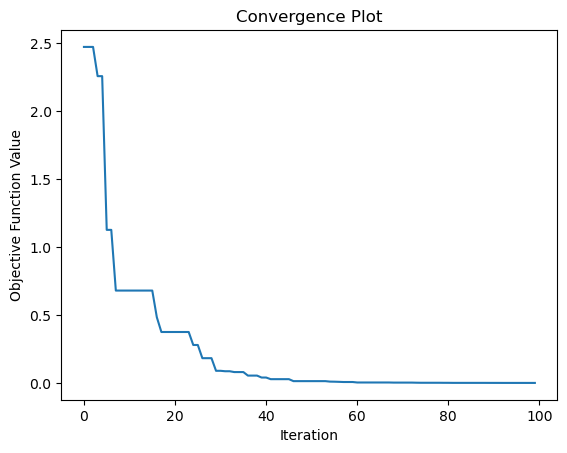

In [44]:
import random
import numpy as np

# 初始化参数
np.random.seed(42)
num_states = 3     # 状态数量
num_actions = 3    # 动作数量
discount_factor = 0.9  # 折扣因子
T = 0.9            # Softmax温度参数

# 初始化Q表，F，CR
Q_table = np.zeros((num_states, num_actions))

# SoftMax函数
def softmax(Q_values, T):
    exp_values = np.exp(Q_values / T)
    return exp_values / np.sum(exp_values)

# 选择动作
def choose_action(state):
    probabilities = softmax(Q_table[state], T)
    return np.random.choice(num_actions, p=probabilities)

# 更新Q表
def update_q_table(current_state, next_state, discount_factor, action, reward):
    learning_rate = 0.1
    Q_table[current_state, action] += learning_rate * (reward 
                                                       + discount_factor * np.max(Q_table[next_state]) 
                                                       - Q_table[current_state, action])

# 差分进化算法的变异和交叉
def differential_evolution(F, CR, X):
    N = len(X)
    for i in range(N):
        a, b, c = np.random.choice(np.delete(np.arange(N), i), 3, replace=False)
        mutant = X[a] + F[i] * (X[b] - X[c])
        trial = np.copy(X[i])
        for j in range(len(X[i])):
            j_rand = np.random.randint(len(X[i]))
            if random.random() < CR[i] or j_rand == j:
                trial[j] = mutant[j]
        yield trial

# 奖励机制
def calculate_reward(parent, offspring):
    if objective_function(offspring) < objective_function(parent):
        return 1
    elif objective_function(offspring) > objective_function(parent):
        return -1
    else:
        return 0

# 伪目标函数
def objective_function(vector):
    return np.sum(vector ** 2)

# 初始种群
population_size = 100
dim = 10
X = np.random.rand(population_size, dim)  # 初始种群
F = np.random.rand(population_size)
CR = np.random.rand(population_size)
current_state = np.random.randint(3, size=population_size)  # 初始状态

# 迭代次数
iterations = 100
new_results = []

# 开始迭代
for t in range(iterations):
    new_population = []
    next_states = np.zeros(population_size, dtype=int)
    rewards = np.zeros(population_size, dtype=int)
    actions = np.zeros(population_size, dtype=int)
    for i, x in enumerate(X):
        action = choose_action(current_state[i])  # 根据状态选择动作
        
        # 根据动作更新F和CR
        F[i] += [-0.1, 0.1, 0][action]
        CR[i] += [0.1, 0.1, 0][action]
        
        if F[i] < 0 or F[i] > 1:
            F[i] = random.random()
        if CR[i] < 0 or CR[i] > 1:
            CR[i] = random.random()
        
        # 生成后代
        trial_vector = next(differential_evolution(F, CR, X))
        
        # 计算奖励并更新Q表
        reward = calculate_reward(x, trial_vector)
        
        # 简化的状态转移
        next_state = [2, 0, 1][reward]
        
        # 如果后代优于父代，则后代成为新的状态
        trial_vector = trial_vector if reward == 1 else x
        
        current_state[i] = next_state
        
        # 保存后代到新种群
        new_population.append(trial_vector)
        
        next_states[i] = next_state
        rewards[i] = reward
        actions[i] = action
    
    for i in range(population_size):    
        # 更新Q表以及状态
        update_q_table(current_state[i], next_states[i], discount_factor, actions[i], rewards[i])
        
    new_results.append(objective_function(trial_vector))
    
    # 更新种群
    X = np.array(new_population)

# 输出结果
print(new_results)

import matplotlib.pyplot as plt

plt.plot(new_results)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergence Plot')
plt.show()
